In [12]:
import time
import random
import string
import matplotlib.pyplot as plt
import logging
from ray.llm._internal.serve.replica_scheduler.prefix_aware.prefix_tree import PrefixTree, PrefixTreeActor


# Disable all warnings and below across the entire application:
logging.disable(logging.WARNING)

def random_digit_string(length: int) -> str:
    return "".join(random.choice(string.digits) for _ in range(length))

async def benchmark_for_size(type_of_tree: str, n_inserts: int, n_samples: int, str_len: int, evict_chars_size: int):
    if type_of_tree == "actor":
        tree = PrefixTreeActor.remote()
    # elif type_of_tree == "deployment":
    #     tree = serve.run(PrefixTreeDeployment.bind())
    elif type_of_tree == "local":
        tree = PrefixTree()

    # Warm-up: n_inserts random strings
    print(f"Inserting {n_inserts} random strings to warm-up...")
    for i in range(n_inserts):
        if type_of_tree == "actor" or type_of_tree == "deployment":
            await tree.insert.remote(random_digit_string(str_len), "tenant_1", time_s=i)
        else:
            tree.insert(random_digit_string(str_len), "tenant_1", time_s=i)

    # Prepare sample inputs
    samples = [random_digit_string(str_len) for _ in range(n_samples)]

    # Benchmark insert
    print(f"Benchmarking {n_samples} insert calls...")
    t0 = time.perf_counter()
    for i, s in enumerate(samples):
        if type_of_tree == "actor" or type_of_tree == "deployment":
            await tree.insert.remote(s, "tenant_1", time_s=n_inserts + i)
        else:
            tree.insert(s, "tenant_1", time_s=n_inserts + i)
    t_insert = (time.perf_counter() - t0) / n_samples * 1e3  # ms
    # Benchmark prefix_match
    print(f"Benchmarking {n_samples} prefix_match calls...")
    t0 = time.perf_counter()
    for s in samples:
        if type_of_tree == "actor" or type_of_tree == "deployment":
            _ = await tree.prefix_match.remote(s)
        else:
            _ = tree.prefix_match(s)
    t_match = (time.perf_counter() - t0) / n_samples * 1e3

    # Benchmark evict_tenant_by_lru
    print(f"Benchmarking {n_samples} evict_tenant_by_lru calls...")
    t0 = time.perf_counter()
    for _ in range(n_samples):
        if type_of_tree == "actor" or type_of_tree == "deployment":
            _ = await tree.evict_tenant_by_lru.remote("tenant_1", evict_chars_size)
        else:
            _ = tree.evict_tenant_by_lru("tenant_1", evict_chars_size)
    t_evict = (time.perf_counter() - t0) / n_samples * 1e3
    return t_insert, t_match, t_evict

async def run_benchmark(tree_sizes: list[int], type_of_tree: str, n_samples: int, str_len: int, evict_chars_size: int):
    insert_times = []
    match_times = []
    evict_times = []
    for size in tree_sizes:
        print(f"Benchmarking tree of size ~{size:,} inserts...")
        t_ins, t_mat, t_evic = await benchmark_for_size(type_of_tree, size, n_samples, str_len, evict_chars_size)
        print(f"  insert: {t_ins:.3f} ms | match: {t_mat:.3f} ms | evict: {t_evic:.3f} ms")
        insert_times.append(t_ins)
        match_times.append(t_mat)
        evict_times.append(t_evic)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(tree_sizes, insert_times, marker="o", label="insert()")
    plt.plot(tree_sizes, match_times,  marker="s", label="prefix_match()")
    plt.plot(tree_sizes, evict_times,   marker="^", label="evict_tenant_by_lru()")
    plt.xscale("log")
    plt.xlabel("Number of inserts in tree")
    plt.ylabel("Average latency per call (ms)")
    plt.title(f"PrefixTree ({type_of_tree}, doubly linked list): PrefixTree operation latency vs. tree size")
    plt.legend()
    plt.grid(which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


Benchmarking tree of size ~1,000 inserts...
Inserting 1000 random strings to warm-up...
Benchmarking 100 insert calls...
Benchmarking 100 prefix_match calls...
Benchmarking 100 evict_tenant_by_lru calls...
  insert: 0.000 ms | match: 0.001 ms | evict: 0.000 ms
Benchmarking tree of size ~10,000 inserts...
Inserting 10000 random strings to warm-up...
Benchmarking 100 insert calls...
Benchmarking 100 prefix_match calls...
Benchmarking 100 evict_tenant_by_lru calls...
  insert: 0.001 ms | match: 0.001 ms | evict: 0.000 ms
Benchmarking tree of size ~100,000 inserts...
Inserting 100000 random strings to warm-up...
Benchmarking 100 insert calls...
Benchmarking 100 prefix_match calls...
Benchmarking 100 evict_tenant_by_lru calls...
  insert: 0.000 ms | match: 0.001 ms | evict: 0.000 ms


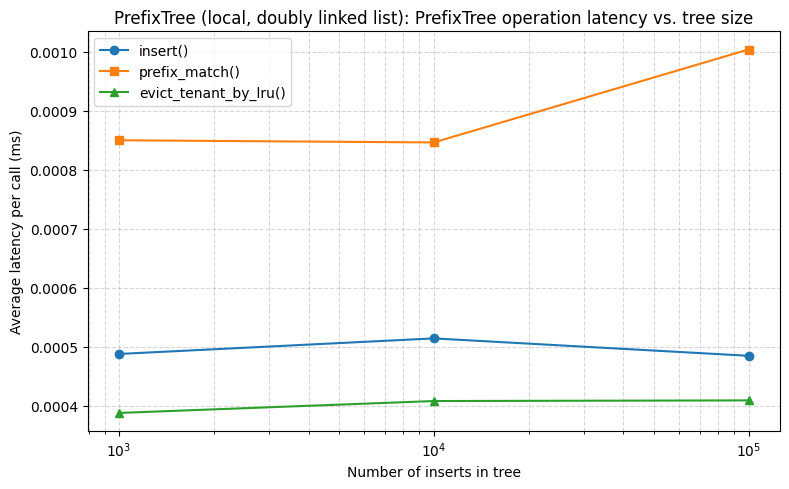

Total time taken: 27.203248262405396 seconds


In [15]:
start_time = time.time()
await run_benchmark(
    tree_sizes=[10**3, 10**4, 10**5],
    type_of_tree="local",
    n_samples=100,
    str_len=1000,
    evict_chars_size=10
)
end_time = time.time()
print(f"Total time taken: {end_time - start_time} seconds")